In [26]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

In [27]:
def resetParameters():
    global timePerWord
    global retrievalTimeWord
    global retrievalTimeSentence
    global steeringUpdateTime
    global startingPositionInLane
    global gaussDeviateMean
    global gaussDeviateSD
    global gaussDriveNoiseMean
    global gaussDriveNoiseSD
    global timeStepPerDriftUpdate
    global maxLateralVelocity
    global minLateralVelocity
    global startvelocity
    global wordsPerMinuteMean
    global wordsPerMinuteSD

    timePerWord = 0  ### ms

    retrievalTimeWord = 200   #ms
    retrievalTimeSentence = 300 #ms

    steeringUpdateTime = 250    #in ms
    startingPositionInLane = 0.27 			#assume that car starts already away from lane centre (in meters)


    gaussDeviateMean = 0
    gaussDeviateSD = 0.13 ##in meter/sec
    gaussDriveNoiseMean = 0
    gaussDriveNoiseSD = 0.1	#in meter/sec
    timeStepPerDriftUpdate = 50 ### msec: what is the time interval between two updates of lateral position?
    maxLateralVelocity = 1.7	# in m/s: maximum lateral velocity: what is the maximum that you can steer?
    minLateralVelocity = -1* maxLateralVelocity
    startvelocity = 0 	#a global parameter used to store the lateral velocity of the car
    wordsPerMinuteMean = 39.33
    wordsPerMinuteSD = 10.3

In [28]:
##calculates if the car is not accelerating (m/s) more than it should (maxLateralVelocity) or less than it should (minLateralVelocity)  (done for a vector of numbers)
def velocityCheckForVectors(velocityVectors):
    global maxLateralVelocity
    global minLateralVelocity

    velocityVectorsLoc = velocityVectors

    if (type(velocityVectorsLoc) is list):
            ### this can be done faster with for example numpy functions
        velocityVectorsLoc = velocityVectors
        for i in range(len(velocityVectorsLoc)):
            if(velocityVectorsLoc[i]>1.7):
                velocityVectorsLoc[i] = 1.7
            elif (velocityVectorsLoc[i] < -1.7):
                velocityVectorsLoc[i] = -1.7
    else:
        if(velocityVectorsLoc > 1.7):
            velocityVectorsLoc = 1.7
        elif (velocityVectorsLoc < -1.7):
            velocityVectorsLoc = -1.7

    return velocityVectorsLoc  ### in m/s

In [29]:
## Function to determine lateral velocity (controlled with steering wheel) based on where car is currently positioned. See Janssen & Brumby (2010) for more detailed explanation.
## Lateral velocity update depends on current position in lane. Intuition behind function: the further away you are, the stronger the correction will be that a human makes
def vehicleUpdateActiveSteering(LD):

	latVel = 0.2617 * LD*LD + 0.0233 * LD - 0.022
	returnValue = velocityCheckForVectors(latVel)
	return returnValue ### in m/s

In [30]:
from scipy.stats import norm

def normal_sample(mean,std):
    #x = 1.96  # value at which to evaluate the CDF
    return np.random.normal(loc=mean, scale=std, size=1)

In [31]:
def vehicleDrift():
    driftSpeed = normal_sample(gaussDeviateMean,gaussDeviateSD)
    return velocityCheckForVectors(driftSpeed)

In [32]:
import math

In [141]:
### Function to run a trial. Needs to be defined by students (section 2 and 3 of assignment)
import pandas as pd

def runTrial(nrWordsPerSentence =5,nrSentences=3,nrSteeringMovementsWhenSteering=2, interleaving="word"):
    resetParameters()
    #locPos = []
    #locTime = []
    #locColor = []
    simulation_data = []
    id = 0

    totalTrailTime = 0
    properTime = 0
    trailTime = 0

    carPos = 0
    carPos = startingPositionInLane
    print(carPos)



    wordsPerMinute = normal_sample(wordsPerMinuteMean,wordsPerMinuteSD)
    timePerWord = ( 60 / wordsPerMinute ) * 1000

    if interleaving == "word":
        for sentence in range(nrSentences):
            for word in range(nrWordsPerSentence):
                trailTime = 0

                #locPos.append(carPos)
                #locColor.append("red")
                #locTime.append(properTime)
                #frame.append([carPos.value],["red"],[properTime])

                if word == 0: trailTime += retrievalTimeSentence
                trailTime += retrievalTimeWord
                trailTime += timePerWord
                #print(trailTime)

                driftUpdates = math.floor(trailTime / 50)
                #print(driftUpdates)

                for dr in range(driftUpdates):
                    driftAmount = vehicleDrift()
                    carPos = carPos + driftAmount/20

                    simulation_data.append({
                        "Time": properTime,
                        "Position": carPos,
                        "Color": "red"  # Drifting
                    })

                    properTime += 50

                for steering in range(nrSteeringMovementsWhenSteering):
                    steeringAmount = vehicleUpdateActiveSteering(carPos)
                    carPos = carPos + steeringAmount

                    simulation_data.append({
                        "Time": properTime,
                        "Position": carPos,
                        "Color": "blue"  # Steering
                    })

                    properTime += 250
                    trailTime += 250

                totalTrailTime += trailTime
    else:
        print("okay")

    df = pd.DataFrame(simulation_data)
    df['Position'] = df['Position'].str[0].astype(float)
    return df


In [34]:
### function to run multiple simulations. Needs to be defined by students (section 3 of assignment)
def runSimulations(nrSims = 100):
    print("hello world")

In [142]:
trailData = runTrial()
trailData

0.27


,Time,Position,Color
0,0,0.270576,red
1,50,0.279384,red
2,100,0.293188,red
3,150,0.288431,red
4,200,0.284200,red
...,...,...,...
538,32500,0.170594,red
539,32550,0.167110,red
540,32600,0.169655,red
541,32650,0.159140,blue


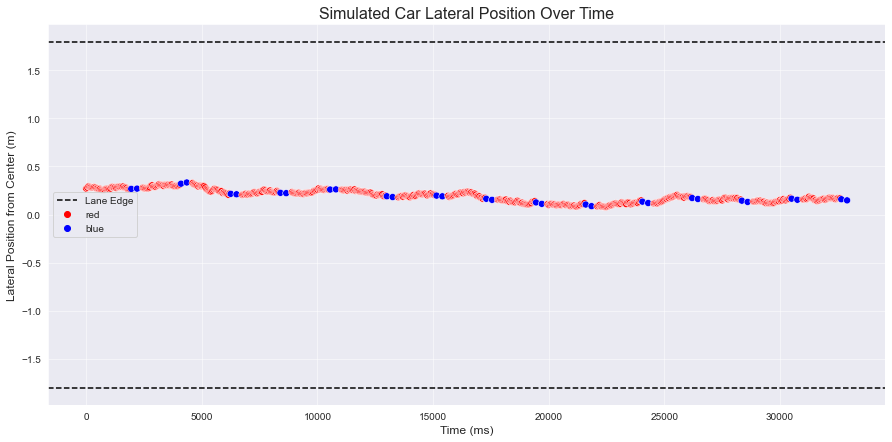

In [143]:
# This plotting code now works correctly with the clean `trailData` DataFrame
plt.figure(figsize=(15, 7))

# Use seaborn's scatterplot function
sb.scatterplot(data=trailData, x='Time', y='Position', hue='Color', palette={'red': 'r', 'blue': 'b'}, s=50)

# --- Add Enhancements for Clarity ---
# Add horizontal lines to represent the lane edges
plt.axhline(y=1.8, color='black', linestyle='--', label='Lane Edge')
plt.axhline(y=-1.8, color='black', linestyle='--')

# Add titles and labels
plt.title('Simulated Car Lateral Position Over Time', fontsize=16)
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Lateral Position from Center (m)', fontsize=12)

# Add a legend and a grid
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)

# Display the plot
plt.show()